# EEG Data Statistics

`01_Data_Curation1`과 `02_Data_Curation2`에서 저장한 EEG 데이터의 분포를 전반적으로 살펴보는 노트북.

-----

## 환경 구성

In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Load some packages
import os
import glob
import json
import datetime
import string

import matplotlib.pyplot as plt
import pprint
from tqdm.auto import tqdm

import numpy as np
import torch
import pyarrow.feather as feather

# custom package
from datasets.caueeg_dataset import CauEegDataset, MultiLabel

In [3]:
# Other settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # cleaner text

plt.style.use('default') 
# ['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 
#  'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 
#  'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 
#  'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 
#  'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']

plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams["font.family"] = 'NanumGothic' # for Hangul in Windows

In [4]:
print(torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available(): print('cuda is available.')
else: print('cuda is unavailable.')

1.11.0+cu113
cuda is available.


-----

## Curated Data 불러오기

In [5]:
# Data file path
curate_folder = r'local/dataset/02_Curated_Data_220416'
output_folder = r'local/output/imgs'

os.makedirs(output_folder, exist_ok=True)

In [6]:
with open(os.path.join(curate_folder, 'annotation_debug.json'), 'r') as json_file:
    annotation = json.load(json_file)

pprint.pprint({k: (v if k != 'data' else v[:5]) for (k, v) in annotation.items()}, width=250)

{'data': [{'age': 78, 'birth': '1940-06-02', 'dx1': 'mci_rf', 'edfname': '00001809_261018', 'record': '2018-10-26T15:46:26', 'serial': '00001', 'symptom': ['mci', 'mci_amnestic', 'mci_amnestic_rf']},
          {'age': 56, 'birth': '1960-12-04', 'dx1': 'smi', 'edfname': '00029426_020817', 'record': '2017-08-02T16:14:56', 'serial': '00002', 'symptom': ['normal', 'smi']},
          {'age': 93, 'birth': '1924-10-19', 'dx1': 'vascular mci', 'edfname': '00047327_090718', 'record': '2018-07-09T15:29:10', 'serial': '00003', 'symptom': ['mci', 'mci_vascular']},
          {'age': 78, 'birth': '1941-03-16', 'dx1': 'load', 'edfname': '00048377_070819', 'record': '2019-08-07T13:55:25', 'serial': '00004', 'symptom': ['dementia', 'ad', 'load']},
          {'age': 75, 'birth': '1941-03-16', 'dx1': 'mci (ef) multi-domain', 'edfname': '00048377_070916', 'record': '2016-09-07T10:36:01', 'serial': '00005', 'symptom': ['mci', 'mci_amnestic', 'mci_amnestic_ef', 'mci_multi_domain']}],
 'dataset_name': 'CAUEE

In [7]:
print(len(annotation["data"]))
print()

pprint.pprint(annotation["data"][0])
print()

fname = os.path.join(curate_folder, 'signal/feather', annotation["data"][0]['serial'] + '.feather')
signal = feather.read_feather(fname)
print(signal.values.T.shape)

signal.head()

1389

{'age': 78,
 'birth': '1940-06-02',
 'dx1': 'mci_rf',
 'edfname': '00001809_261018',
 'record': '2018-10-26T15:46:26',
 'serial': '00001',
 'symptom': ['mci', 'mci_amnestic', 'mci_amnestic_rf']}

(21, 145000)


,Fp1-AVG,F3-AVG,C3-AVG,P3-AVG,O1-AVG,Fp2-AVG,F4-AVG,C4-AVG,P4-AVG,O2-AVG,...,T3-AVG,T5-AVG,F8-AVG,T4-AVG,T6-AVG,FZ-AVG,CZ-AVG,PZ-AVG,EKG,Photic
0,0,29,-3,0,-1,-4,-12,-10,-8,-4,...,-2,3,18,0,-2,16,-6,-4,112,-1
1,-11,33,-6,2,-2,2,-9,-7,-5,-3,...,-4,2,28,4,-1,-3,-7,-2,67,-1
2,-13,34,-3,3,-3,4,-9,-7,-4,-4,...,-5,-2,29,4,-2,-5,-4,1,76,-1
3,-11,36,-1,2,-3,2,-8,-8,-4,-4,...,-6,-5,28,2,-3,-2,-1,2,87,1
4,-7,38,-3,-2,-6,3,-4,-4,-5,-4,...,-8,-7,28,2,-5,4,0,0,74,2


-----

## 총 환자수

In [8]:
a = set()
for m in annotation["data"]:
    a.add(m['edfname'].split('_')[0])

print(len(a))

1164


-----

## 데이터 통계

- Signal dynamic range
- Signal mean and variance
- Signal length
- Age
- Diagnosis

In [9]:
hist_min = []
hist_max = []
hist_mean = []
hist_var = []

hist_length = []
hist_age = []
dict_diagnosis = {}

for (k, m) in enumerate(tqdm(annotation["data"])):
    fname = os.path.join(curate_folder, 'signal/feather', m['serial'] + '.feather')
    signal = feather.read_feather(fname).values.T
    
    hist_min.append(np.amin(signal, axis=1))
    hist_max.append(np.amax(signal, axis=1))
    hist_mean.append(np.mean(signal, axis=1))
    hist_var.append(np.var(signal, axis=1))
    
    hist_length.append(signal.shape[1])
    hist_age.append(m['age'])
    
    # d = MultiLabel(**{k: True for k in m['symptom']})
    for l in m['symptom']:
        dict_diagnosis[l] = dict_diagnosis.get(l, 0) + 1
    
hist_min = np.array(hist_min).T
hist_max = np.array(hist_max).T
hist_mean = np.array(hist_mean).T
hist_var = np.array(hist_var).T

hist_length = np.array(hist_length)
hist_age = np.array(hist_age)

print('Done.')

  0%|          | 0/1389 [00:00<?, ?it/s]

Done.


#### Signal min, max, mean, and var

In [10]:
plt.style.use('default') 

ind = np.argsort(np.sum(hist_max - hist_min, axis=0))

for i in tqdm(range(len(annotation["signal_header"]))):
    fig = plt.figure(num=1, clear=True, 
                 figsize=(60.0, 40.0), constrained_layout=True)

    ax = fig.add_subplot(1, 1, 1)
    ax.plot(hist_min[i, ind], 'b--', linewidth=1.2, label='min')
    ax.plot(hist_max[i, ind], 'c--', linewidth=1.2, label='max')
    ax.plot(hist_mean[i, ind], 'r-', linewidth=1.2, label='mean')
    ax.fill_between(np.arange(hist_mean[i].shape[0]),
                    hist_mean[i, ind] - hist_var[i, ind] / 20, 
                    hist_mean[i, ind] + hist_var[i, ind] / 20, 
                    color='m', alpha=0.4, label='var')

    ax.set_title(annotation["signal_header"][i], fontsize=70)
    plt.legend(loc='upper center', shadow=True, fontsize=70).get_frame().set_facecolor('white')

    fig.savefig(os.path.join(output_folder, f'signal_statistics_c{i + 1:02}.png'))

    fig.clear()
    plt.close(fig)
    
print('Done.')

  0%|          | 0/21 [00:00<?, ?it/s]

Done.


#### Signal length

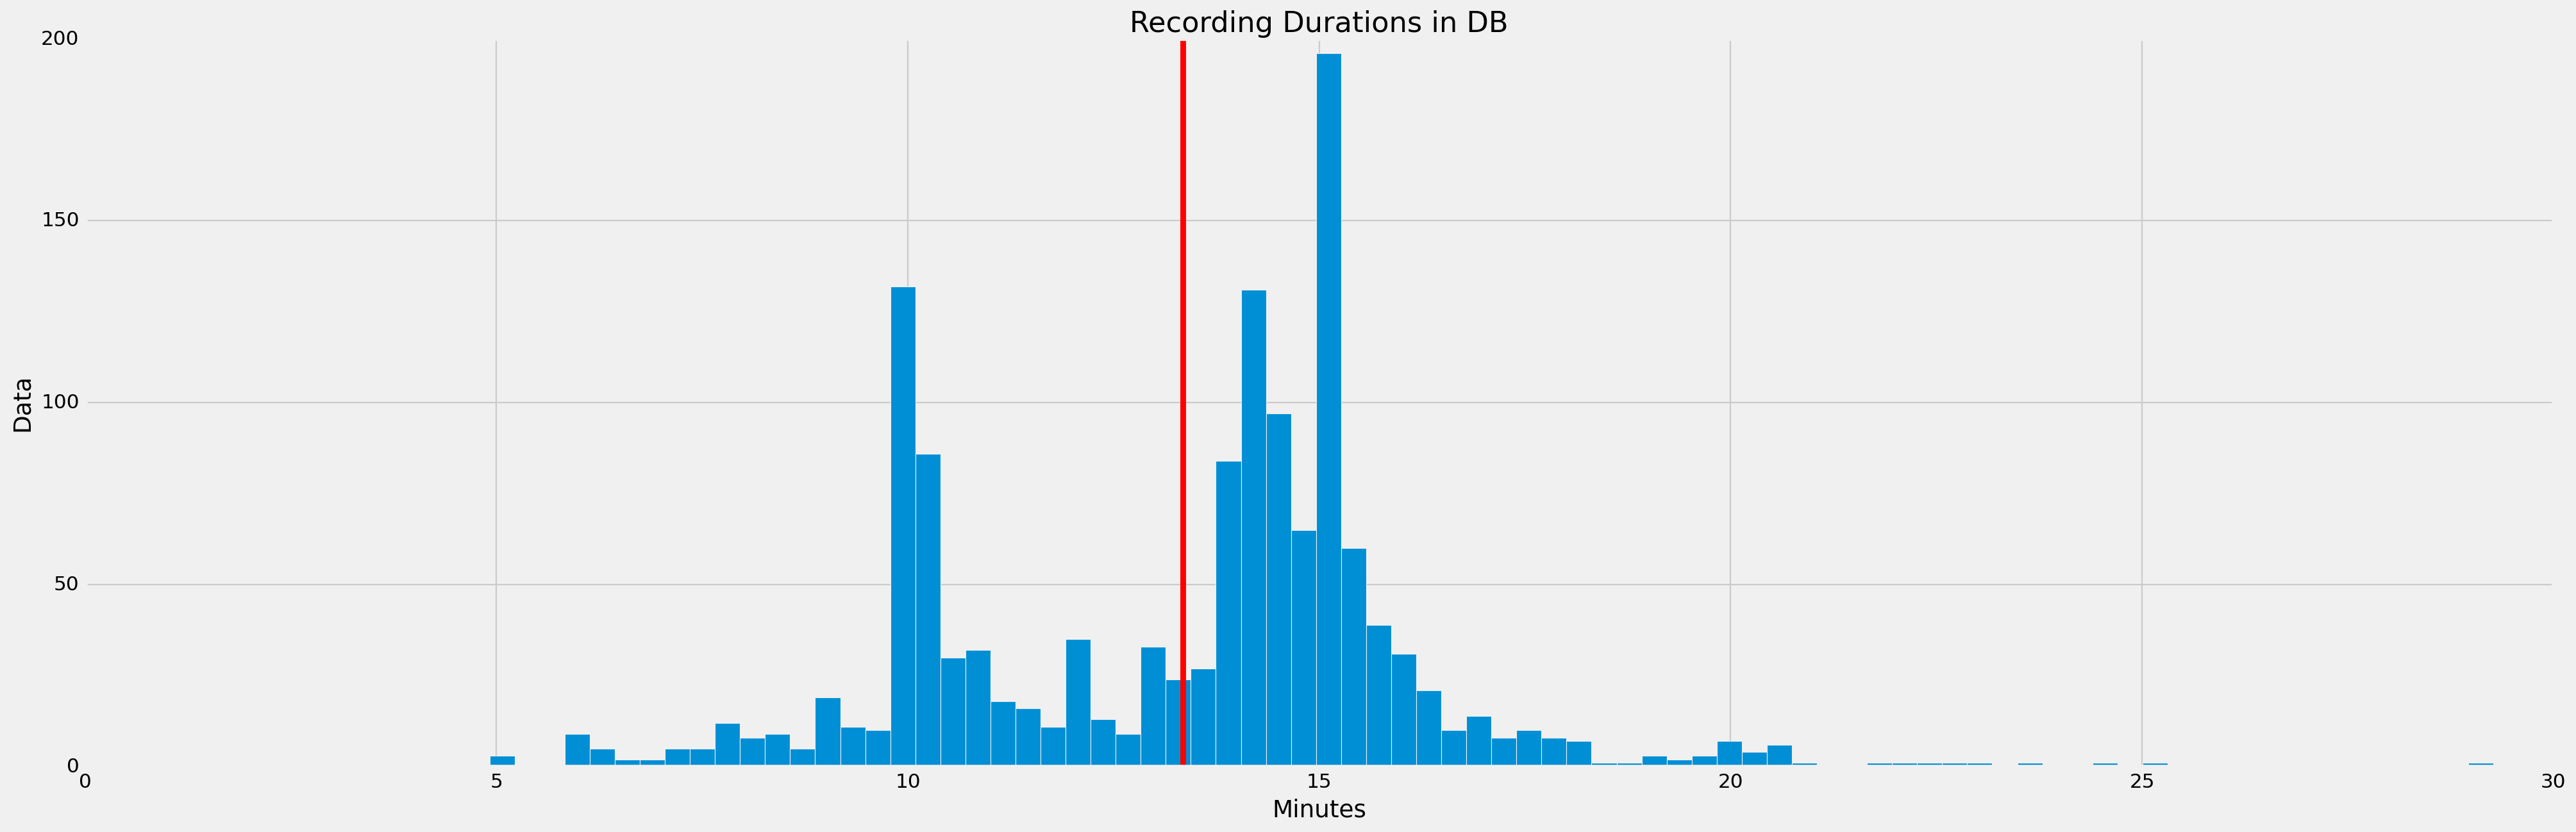

In [11]:
plt.style.use('classic')
plt.style.use('fivethirtyeight') # default, ggplot, fivethirtyeight, classic

fig = plt.figure(num=1, clear=True, 
                 figsize=(25.0, 8.0), constrained_layout=True)

ax = fig.add_subplot(1, 1, 1)
ax.hist(hist_length / (60 * 200), bins=80)
ax.vlines(np.mean(hist_length) / (60 * 200), 0, 1, transform=ax.get_xaxis_transform(), colors='r')
ax.set_title('Recording Durations in DB')
ax.set_xlabel('Minutes')
ax.set_ylabel('Data')

fig.savefig(os.path.join(output_folder, 'signal_length_distribution.png'))

plt.show()
fig.clear()
plt.close(fig)

#### Age

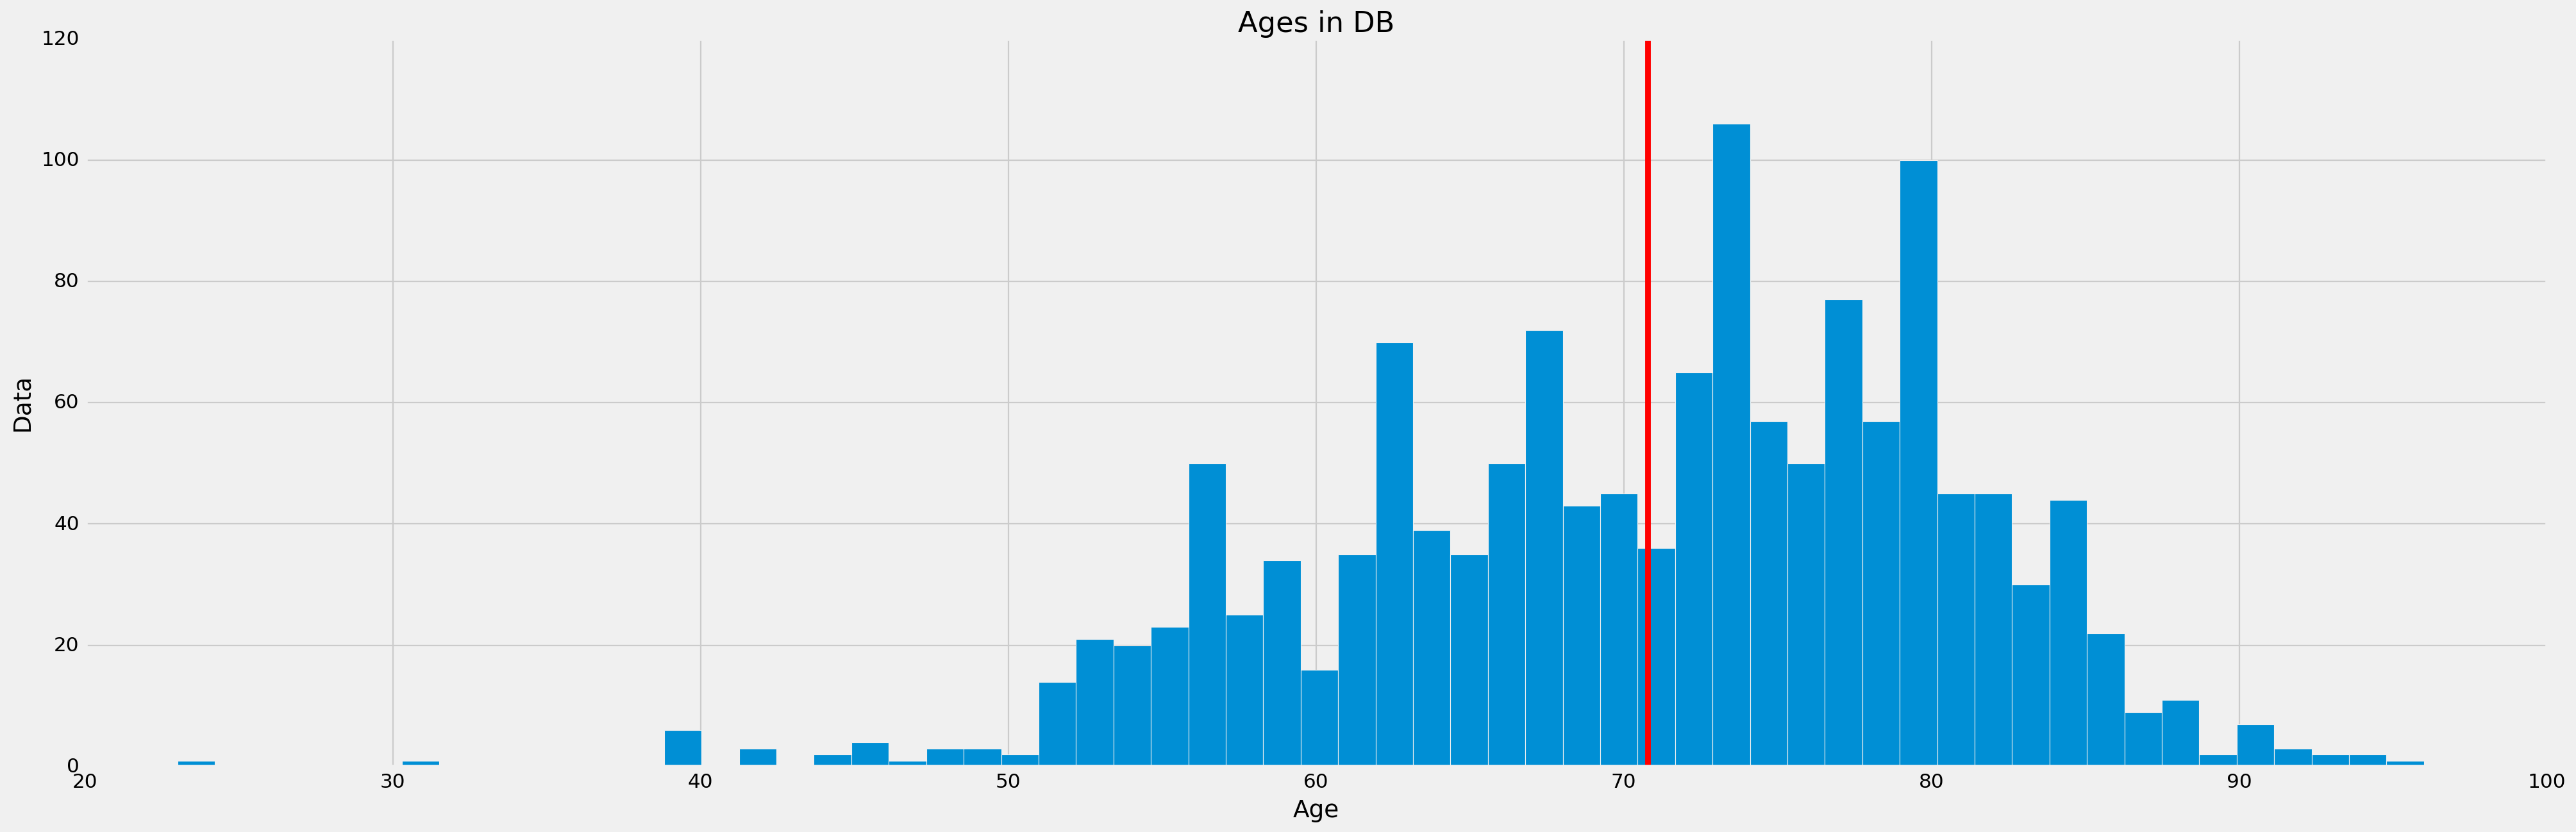

In [12]:
plt.style.use('classic')
plt.style.use('fivethirtyeight') # default, ggplot, fivethirtyeight, classic

fig = plt.figure(num=1, clear=True, 
                 figsize=(25.0, 8.0), constrained_layout=True)

ax = fig.add_subplot(1, 1, 1)
ax.hist(hist_age, bins=60)
ax.vlines(np.mean(hist_age), 0, 1, transform=ax.get_xaxis_transform(), colors='r')
ax.set_title('Ages in DB')
ax.set_xlabel('Age')
ax.set_ylabel('Data')

fig.savefig(os.path.join(output_folder, 'age_distribution.png'))

plt.show()
fig.clear()
plt.close(fig)

[70.76601872]
[9.89174508]


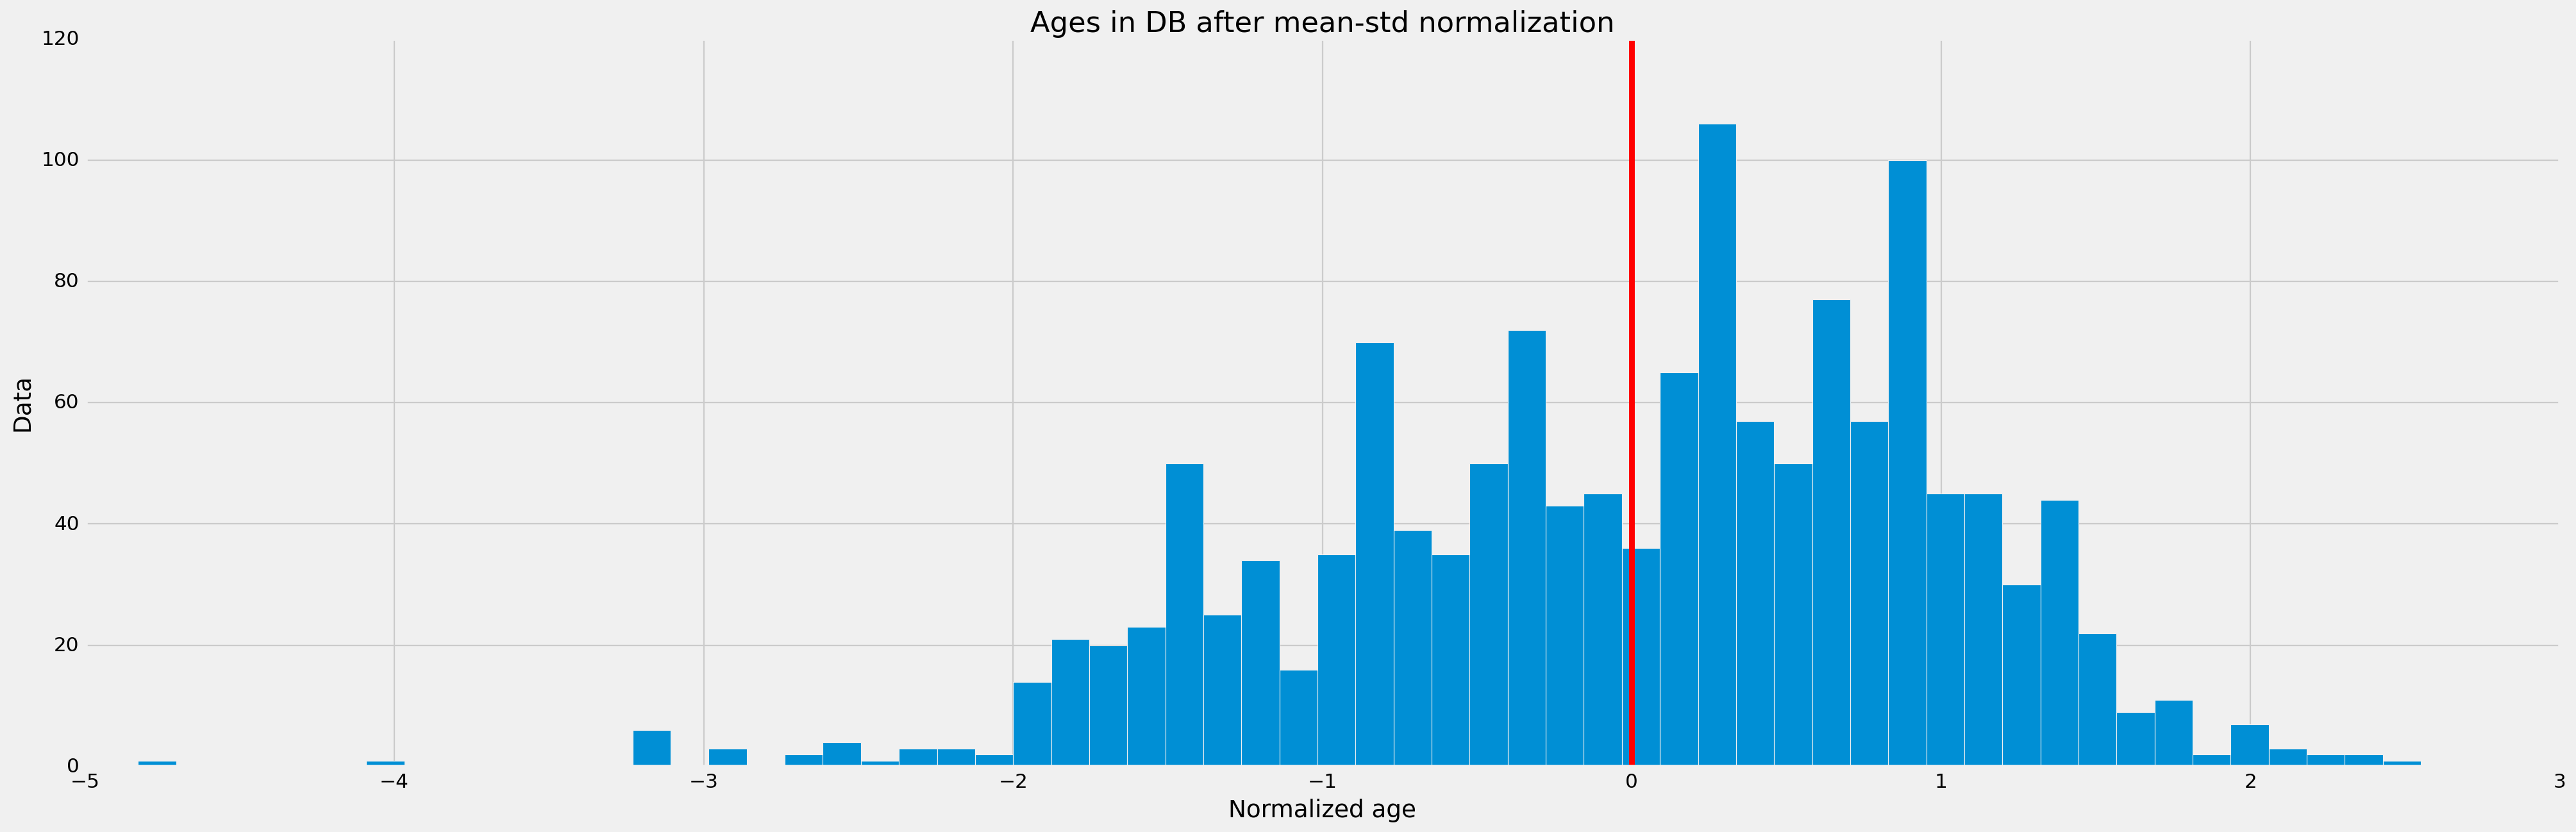

In [13]:
m = np.mean(hist_age, keepdims=True)
std = np.std(hist_age, keepdims=True)
hist_age_norm = (hist_age - m) / (std + 1e-8)

print(m)
print(std)

plt.style.use('classic')
plt.style.use('fivethirtyeight') # default, ggplot, fivethirtyeight, classic

fig = plt.figure(num=1, clear=True, 
                 figsize=(25.0, 8.0), constrained_layout=True)

ax = fig.add_subplot(1, 1, 1)
ax.hist(hist_age_norm, bins=60)
ax.vlines(np.mean(hist_age_norm), 0, 1, transform=ax.get_xaxis_transform(), colors='r')
ax.set_title('Ages in DB after mean-std normalization')
ax.set_xlabel('Normalized age')
ax.set_ylabel('Data')

fig.savefig(os.path.join(output_folder, 'age_distribution_norm.png'))

plt.show()
fig.clear()
plt.close(fig)

#### Diagnosis

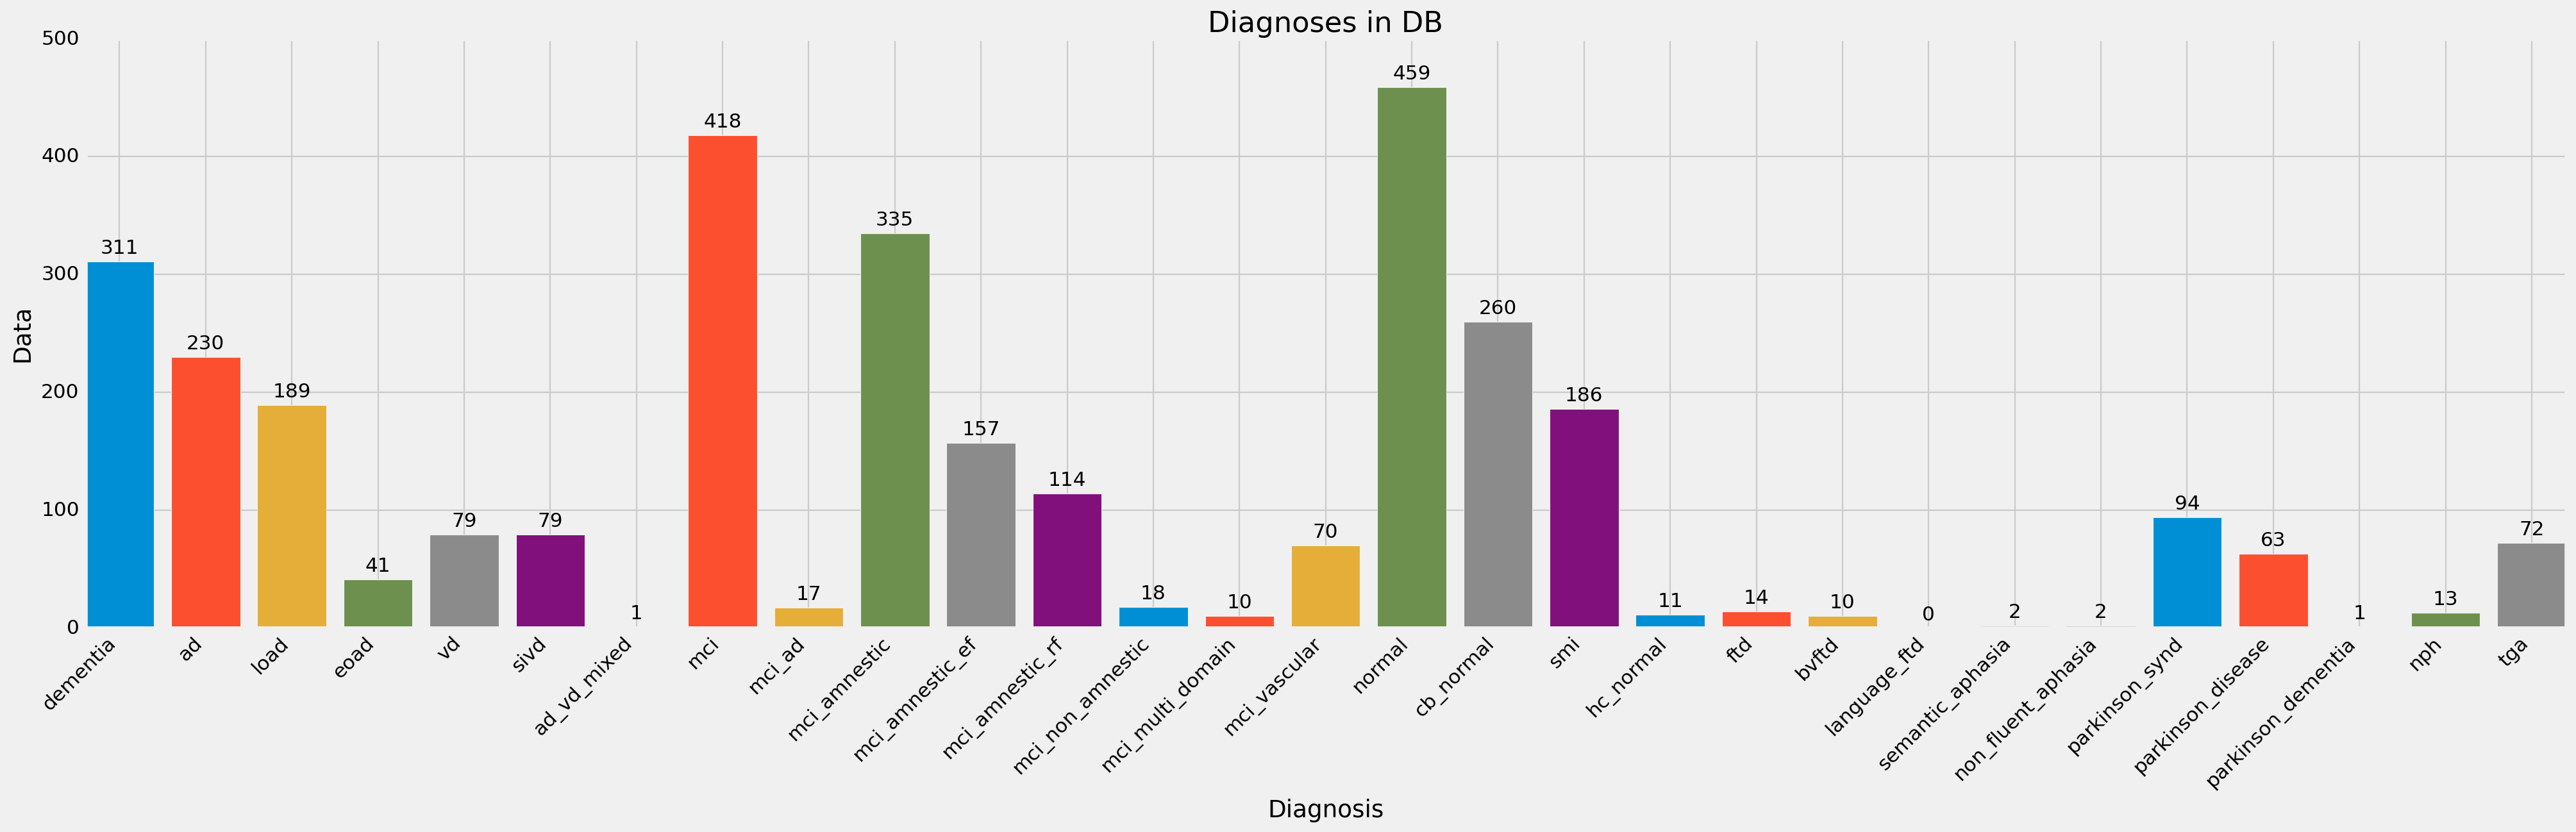

In [14]:
plt.style.use('fivethirtyeight') # default, ggplot, fivethirtyeight, classic

from cycler import cycler
cc = cycler(color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
                   'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'])

fig = plt.figure(num=1, clear=True, 
                 figsize=(25.0, 8.0), constrained_layout=True)

ax = fig.add_subplot(1, 1, 1)
for d, c in zip(MultiLabel().get_label_types(), cc()):
    rect = ax.bar(d, dict_diagnosis.get(d, 0))
    ax.bar_label(rect, padding=3)
    
# rect = ax.bar(*zip(*dict_diagnosis.items()))
# ax.bar_label(rect, padding=3)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_title('Diagnoses in DB')
ax.set_xlabel('Diagnosis')
ax.set_ylabel('Data')

fig.savefig(os.path.join(output_folder, 'diagnosis_distribution.png'))

plt.show()
fig.clear()
plt.close(fig)

-----

## 전처리 방법 모색하기

#### Signal min, max, mean, and var after per-signal mean-std normalization

In [15]:
hist_min_norm = []
hist_max_norm = []
hist_mean_norm = []
hist_var_norm = []

for (k, m) in enumerate(tqdm(annotation["data"])):
    fname = os.path.join(curate_folder, 'signal/feather', m['serial'] + '.feather')
    signal = feather.read_feather(fname).values.T    
    
    m = np.mean(signal, axis=1, keepdims=True)
    std = np.std(signal, axis=1, keepdims=True)
    signal = (signal - m) / (std + 1e-8)
    
    hist_min_norm.append(np.amin(signal, axis=1))
    hist_max_norm.append(np.amax(signal, axis=1))
    hist_mean_norm.append(np.mean(signal, axis=1))
    hist_var_norm.append(np.var(signal, axis=1))
    
hist_min_norm = np.array(hist_min_norm).T
hist_max_norm = np.array(hist_max_norm).T
hist_mean_norm = np.array(hist_mean_norm).T
hist_var_norm = np.array(hist_var_norm).T

print('Done.')

  0%|          | 0/1389 [00:00<?, ?it/s]

Done.


In [16]:
plt.style.use('default') 

# ind = np.argsort(np.sum(hist_max_norm - hist_min_norm, axis=0))
ind = np.argsort(np.sum(hist_max - hist_min, axis=0))

for i in tqdm(range(len(annotation["signal_header"]))):
    fig = plt.figure(num=1, clear=True, 
                 figsize=(60.0, 40.0), constrained_layout=True)

    ax = fig.add_subplot(1, 1, 1)
    ax.plot(hist_min_norm[i, ind], 'b--', linewidth=1.2, label='min')
    ax.plot(hist_max_norm[i, ind], 'c--', linewidth=1.2, label='max')
    ax.plot(hist_mean_norm[i, ind], 'r-', linewidth=1.2, label='mean')
    ax.fill_between(np.arange(hist_mean_norm[i].shape[0]),
                    hist_mean_norm[i, ind] - hist_var_norm[i, ind], 
                    hist_mean_norm[i, ind] + hist_var_norm[i, ind], 
                    color='m', alpha=0.4, label='var')

    ax.set_title(annotation["signal_header"][i] + ' after per-signal mean-std normalization', fontsize=70)
    plt.legend(loc='upper center', shadow=True, fontsize=70).get_frame().set_facecolor('white')

    fig.savefig(os.path.join(output_folder, f'signal_statistics_c{i + 1:02}_norm.png'))

    fig.clear()
    plt.close(fig)
    
print('Done.')

  0%|          | 0/21 [00:00<?, ?it/s]

Done.


-----

## 이벤트 종류 및 발생 빈도수

In [17]:
event_dict = dict()

for m in annotation["data"]:
    fname = os.path.join(curate_folder, 'event', m['serial'] + '.json')
    with open(fname, 'r') as json_file:
        event = json.load(json_file)
    
    for (t, e) in event:
        event_dict[e] = event_dict.get(e, 0) + 1
        
pprint.pprint(sorted(event_dict.items(), key=lambda x: x[1], reverse=True))

[('Eyes Closed', 16910),
 ('Eyes Open', 16857),
 ('Photic Off', 10472),
 ('Paused', 1876),
 ('Move', 1777),
 ('Start Recording', 1389),
 ('New Montage - Montage 002', 1102),
 ('Photic On - 3.0 Hz', 1073),
 ('Photic On - 6.0 Hz', 1065),
 ('Photic On - 9.0 Hz', 1063),
 ('Photic On - 12.0 Hz', 1060),
 ('Photic On - 15.0 Hz', 1054),
 ('Photic On - 21.0 Hz', 1051),
 ('Photic On - 18.0 Hz', 1048),
 ('Photic On - 24.0 Hz', 1035),
 ('Photic On - 27.0 Hz', 1023),
 ('Photic On - 30.0 Hz', 980),
 ('Recording Resumed', 492),
 ('artifact', 366),
 ('swallowing', 232),
 ('New Montage - Pz Montage', 163),
 ('New Montage - Montage 005', 147),
 ('HV - Off', 99),
 ('cough', 53),
 ('HV fair', 51),
 ('Talk', 51),
 ('chewing', 47),
 ('passive eye close', 36),
 ('A1 recheck', 24),
 ('HV Fair', 23),
 ('Artifact', 23),
 ('eye blinking -->>', 21),
 ('sleep Try', 20),
 ('A2 recheck', 18),
 ('eye blinking', 17),
 ('T3 check', 15),
 ('T4 recheck', 13),
 ('Couch', 13),
 ('F4 recheck', 12),
 ('A2 Recheck', 12),
 ('s

-----

## 이벤트 전후의 신호열 시각화

In [18]:
for m in tqdm(annotation["data"][:10]):
    
    path = os.path.join(output_folder, m["serial"])
    os.makedirs(path, exist_ok=True)
    
    fname = os.path.join(curate_folder, 'signal/feather', m['serial'] + '.feather')
    signal = feather.read_feather(fname).values.T
    
    fname = os.path.join(curate_folder, 'event', m['serial'] + '.json')
    with open(fname, 'r') as json_file:
        event = json.load(json_file)
    
    for i, (t, e) in enumerate(event):
        fig = plt.figure(num=1, clear=True, 
                         figsize=(14.0, 5), constrained_layout=True)
        ax = fig.add_subplot(1, 1, 1)

        width = 400
        st, et = t - width, t + width
        if st < 0: 
            st, et = 0, width*2
        elif signal.shape[1] < et: 
            st, et = signal.shape[1] - width*2, signal.shape[1]

        for (k, h) in enumerate(annotation["signal_header"]):
            ax.plot(np.arange(st, et) / 200, signal[k, st:et], label=h)
            ax.vlines([t / 200], 0, 1, transform=ax.get_xaxis_transform(), colors='r')

        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_title(e)

        fname = f'{str(i+1):>03}_{e}.png'
        safechars = string.ascii_lowercase + string.ascii_uppercase + string.digits + '.-_'
        fname = ''.join([c for c in fname if c in safechars])

        fig.savefig(os.path.join(path, fname))
        fig.clear()
        plt.close(fig)
        
print('Done.')

  0%|          | 0/10 [00:00<?, ?it/s]

Done.


-----

## Eye open 과 Eye closed 이벤트 사이의 시간 간격 시각화

In [19]:
for m in annotation["data"]:
    started = True
    opened = False
    t = 0
    intervals = []
    warns = []
    
    fname = os.path.join(curate_folder, 'event', m['serial'] + '.json')
    with open(fname, 'r') as json_file:
        event = json.load(json_file)
    
    for e in event:
        if e[1].lower() == 'eyes open':
            if started:
                started = False
                t = e[0]
                opened = True
            elif opened:
                t = e[0]
                warns.append(f'open-open: {e}')
            else:
                t = e[0]
                opened = True
        elif e[1].lower() == 'eyes closed':
            if started:
                started = False
                opened = False
            elif opened:
                opened = False
                intervals.append(e[0] - t)
            else:
                warns.append(f'close-close: {e}')

    print(m['serial'], warns, intervals)

00001 [] [36122, 1386, 1428, 1008, 1050, 1304, 966, 1260, 924, 924, 1260, 1084, 1596]
00002 [] [4872, 8232, 5712, 6006, 6090, 6678, 6174, 5922, 5880, 5418, 3570, 1974, 2394, 672, 798, 798, 588, 1680]
00003 [] [36674, 1806, 784, 966, 1639]
00004 [] [6930, 5250, 4998, 5424, 6846, 5964, 1008, 1010, 1008, 1344, 840, 798, 913, 3732, 840, 1008, 1848, 1746, 1092]
00005 ["close-close: [25939, 'Eyes Closed']"] [1428, 2017, 1133, 1134, 672, 630, 714, 798, 714, 1008, 1386, 1344, 2184, 1596, 1260, 1134, 1848, 1344, 1637, 1134, 1516, 1176, 1260, 1554, 1008, 1176, 1260, 1428]
00006 [] [5796, 5670, 5419, 6048, 5754, 5418, 1428, 1438, 882, 1134, 881, 1176, 0, 1344, 1386, 1218]
00007 [] [1638, 1092, 1050, 1218, 924, 966, 1008, 1134, 1218, 1050, 966, 882, 714, 1050, 1260, 966, 1092, 882, 966]
00008 [] [1260, 966, 882, 1134, 882, 756, 882, 1386, 998, 1316, 1134, 1008]
00009 [] [36246, 714, 1136, 672, 966, 1007, 1050, 1092]
00010 [] [35794, 1890, 2016, 462, 588, 1428, 2520]
00011 [] [5126, 5838, 5712, 521

In [20]:
for m in annotation["data"]:
    started = True
    opened = False
    t = 0
    intervals = []
    warns = []
    
    fname = os.path.join(curate_folder, 'event', m['serial'] + '.json')
    with open(fname, 'r') as json_file:
        event = json.load(json_file)
    
    for e in event:
        if e[1].lower() == 'eyes open':
            if started:
                started = False
                opened = True
            elif opened:
                warns.append(f'open-open: {e}')
            else:
                intervals.append(e[0] - t)
                opened = True
        elif e[1].lower() == 'eyes closed':
            if started:
                started = False
                opened = False
                t = e[0]
            elif opened:
                opened = False
                t = e[0]
            else:
                t = e[0]
                warns.append(f'close-close: {e}')

    print(m['serial'], warns, intervals)

00001 [] [1344, 2730, 882, 3192, 5920, 1980, 6888, 3024, 3276, 2860, 19460, 3150]
00002 [] [6390, 3654, 6174, 5964, 5712, 5460, 5838, 17934, 9282, 10336, 12936, 2520, 2058, 3528, 7140, 7560, 18104]
00003 [] [33852, 4578, 6818, 9256, 27551]
00004 [] [3990, 6342, 6048, 7308, 7056, 5212, 9240, 1848, 3192, 4750, 4914, 13776, 3822, 2983, 5938, 3864, 4620, 7874, 1810]
00005 ["close-close: [25939, 'Eyes Closed']"] [4579, 4368, 2059, 4243, 3318, 3444, 3360, 7690, 13616, 11760, 1974, 4788, 5502, 8442, 1932, 2100, 2730, 11802, 1513, 1890, 7602, 1428, 1974, 13364, 1344, 1470, 7398]
00006 [] [4710, 6384, 5963, 6636, 6342, 6090, 3360, 7194, 3380, 16452, 11046, 7141, 6382, 7142, 13568, 3192]
00007 [] [4252, 4537, 4159, 5544, 13356, 5838, 4242, 7434, 5424, 5124, 21214, 10206, 6888, 16632, 9240, 9618, 7854, 12390]
00008 [] [7014, 7308, 6006, 7434, 10878, 18942, 15960, 370, 1466, 2498, 2508]
00009 [] [1050, 6594, 2562, 5334, 11172, 29783, 20622]
00010 [] [2436, 2898, 1218, 3654, 9534, 96002, 2730]
0001

-----

## Spectrogram 생김새 확인

#### PyTorch stft function

In [21]:
# plt.style.use('ggplot')
# plt.rcParams['figure.figsize'] = (8, 4) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'jet' # 'nipy_spectral'

for m in tqdm(annotation["data"][:2]):
    fname = os.path.join(curate_folder, 'signal/feather', m['serial'] + '.feather')
    signal = feather.read_feather(fname).values.T
    signal = torch.from_numpy(signal).to(dtype=torch.float32)
    signal_f = torch.stft(signal, n_fft=200, center=True, return_complex=True)
    
    # Signiture: (input, n_fft, hop_length=None, 
    #             win_length=None, window=None, center=True, 
    #             pad_mode='reflect', normalized=False, 
    #             onesided=None, return_complex=None)    
    
    print(signal.shape, signal_f.shape, signal.shape[1] / (200 / 4) + 1)
    
    signal_f = torch.view_as_real(signal_f).numpy()[..., 0]
    channels = signal_f.shape[0]
    
    fig = plt.figure(num=1, clear=True, figsize=(30.0, 30.0), 
                     constrained_layout=True)
    
    for k in range(channels):
        ax = fig.add_subplot(channels // 7, 7, k + 1)
        ax.imshow(signal_f[k], interpolation='nearest')
        ax.set_title(annotation["signal_header"][k], fontsize=14)
        ax.invert_yaxis()
    fig.suptitle('Spectrograms: ({}, {})'.format(m['serial'], m['dx1']), fontsize=23)
    fig.supxlabel('Time (s)', fontsize=20)
    fig.supylabel('Frequency (Hz)', fontsize=20)
    plt.savefig(os.path.join(output_folder, f'{m["serial"]}.png'))
    
    fig.clear()
    plt.close(fig)
    
print('Done.')

  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([21, 145000]) torch.Size([21, 101, 2901]) 2901.0
torch.Size([21, 207600]) torch.Size([21, 101, 4153]) 4153.0
Done.


#### MatPlotLib specgram function

In [22]:
for m in tqdm(annotation["data"][:2]):
    fname = os.path.join(curate_folder, 'signal/feather', m['serial'] + '.feather')
    signal = feather.read_feather(fname).values.T
    
    fig, ax = plt.subplots(3, 7, figsize=(30.0, 10.0),
                           constrained_layout=True)
    for k in range(21):
        Pxx, freqs, bins, im = ax[k // 7, k % 7].specgram(signal[k, :12000], 200, 200)
        ax[k // 7, k % 7].set_title(annotation["signal_header"][k], fontsize=14)
        ax[k // 7, k % 7].invert_yaxis()
        # ax[k // 7, k % 7].set_xlabel('Time (s)')
        # ax[k // 7, k % 7].set_ylabel('')
        
    fig.suptitle('Spectrograms: ({}, {})'.format(m['serial'], m['dx1']), fontsize=23)
    fig.supxlabel('Time (s)', fontsize=20)
    fig.supylabel('Frequency (Hz)', fontsize=20)
    plt.savefig(os.path.join(output_folder, f'{m["serial"]}.png'))
    plt.close('all')
    
print('Done.')

  0%|          | 0/2 [00:00<?, ?it/s]

Done.


#### Real vs Complex

In [23]:
for m in tqdm(annotation["data"][:2]):
    fname = os.path.join(curate_folder, 'signal/feather', m['serial'] + '.feather')
    signal = feather.read_feather(fname).values.T
    signal = torch.from_numpy(signal).to(dtype=torch.float32)
    signal_f = torch.stft(signal, n_fft=200, center=True, return_complex=True)
    
    # Signiture: (input, n_fft, hop_length=None, 
    #             win_length=None, window=None, center=True, 
    #             pad_mode='reflect', normalized=False, 
    #             onesided=None, return_complex=None)    
    
    print(signal.shape, signal_f.shape, signal.shape[1] / (200 / 4) + 1)
    
    signal_f = torch.view_as_real(signal_f)
    signal_f_real = signal_f[..., 0]
    signal_f_complex = torch.flip(-signal_f[..., 1], dims=[0])
    
print('Done.')

  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([21, 145000]) torch.Size([21, 101, 2901]) 2901.0
torch.Size([21, 207600]) torch.Size([21, 101, 4153]) 4153.0
Done.
